In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, Activation, Dropout, concatenate
from tensorflow.keras.losses import mse
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.losses import mse, binary_crossentropy

from IPython.display import SVG

from tensorflow.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

parallelization_factor = 5

config = tf.ConfigProto(inter_op_parallelism_threads=parallelization_factor,
                      intra_op_parallelism_threads=parallelization_factor)
sess = tf.Session(config=config)

config.gpu_options.allow_growth=True

## Load BRCA labelled data and ARCHS4 BRCA data

In [2]:
X_brca_train = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_train.pkl")
X_archs4_brca = pd.read_pickle("../data/archs4_brca_tissue_cell_row_log_normalized.pkl")

### Preprocess BRCA labelled data

In [3]:
y_brca_train = X_brca_train["Ciriello_subtype"]
X_brca_train.drop(['tcga_id', 'Ciriello_subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

scaler = MinMaxScaler()
X_autoencoder = X_archs4_brca
X_autoencoder_scaled = pd.DataFrame(scaler.fit_transform(X_autoencoder), columns=X_autoencoder.columns)

## Initialize variables and hyperparameters

In [4]:
original_dim = X_autoencoder_scaled.shape[1]
input_shape = (original_dim,)
intermediate_dim = 300
latent_dim = 100

batch_size = 50
epochs = 100
learning_rate = 0.001

dropout_rate_input = 0.8
dropout_rate_hidden = 0.4

## Define functions

In [5]:
def sampling(args):
    
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(y_true, y_pred):
    # E[log P(X|z)]
    reconstruction_loss = original_dim * binary_crossentropy(y_true, y_pred) # because it returns the mean cross-entropy
    # reconstruction_loss = mse(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl_loss = -0.5 * K.sum(1. + z_log_var_encoded - K.exp(z_log_var_encoded) - K.square(z_mean_encoded), axis=1)

    return K.mean(reconstruction_loss + kl_loss)

## Build Encoder

In [6]:
inputs = Input(shape=(original_dim, ), name="encoder_input")

dropout_input = Dropout(rate=dropout_rate_input)(inputs)

hidden_dense = Dense(intermediate_dim)(dropout_input)
hidden_dense_batchnorm = BatchNormalization()(hidden_dense)
hidden_dense_encoded = Activation("relu")(hidden_dense_batchnorm)

dropout_encoder_hidden = Dropout(rate=dropout_rate_hidden)(hidden_dense_encoded)

z_mean_dense = Dense(latent_dim)(dropout_encoder_hidden)
z_log_var_dense = Dense(latent_dim)(dropout_encoder_hidden)

# Latent representation layers
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense)
z_mean_encoded = Activation("relu")(z_mean_dense_batchnorm)

z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense)
z_log_var_encoded = Activation("relu")(z_log_var_dense_batchnorm)

# Sample z
z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean_encoded, z_log_var_encoded])

encoder = Model(inputs, [z_mean_encoded, z_log_var_encoded], name="encoder")
encoder.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 19036)        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 19036)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          5711100     dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v

In [7]:
encoder_get_embedding = Model(inputs, z, name="encoder_get_embedding")
encoder_get_embedding.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 19036)        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 19036)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          5711100     dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 300)          1200        dense[0][0]                      
__________________________________________________________________________________________________
activation

## Build Decoder 

In [8]:
decoder_hidden = Dense(intermediate_dim, activation="relu", name="decoder_hidden")
decoder_output = Dense(original_dim, activation="sigmoid", name="decoder_output")

vae_decoder_hidden = decoder_hidden(z)

decoder_dropout = Dropout(rate=dropout_rate_hidden)
decoder_hidden_dropout = decoder_dropout(vae_decoder_hidden)
outputs = decoder_output(decoder_hidden_dropout)

## Build Variational Autoencoder

In [9]:
adam = optimizers.Adam(lr=learning_rate)
vae = Model(inputs, outputs, name='vae')
vae.compile(optimizer=adam, loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 19036)        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 19036)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          5711100     dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 300)          1200        dense[0][0]                      
__________________________________________________________________________________________________
activation

## Train the Model

In [10]:
#Split validation set
test_set_percent = 0.2
X_autoencoder_val = X_autoencoder_scaled.sample(frac=test_set_percent)
X_autoencoder_train = X_autoencoder_scaled.drop(X_autoencoder_val.index)

In [11]:
type(X_autoencoder_val)

pandas.core.frame.DataFrame

In [12]:
fit_hist = vae.fit(X_autoencoder_train, X_autoencoder_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=400)],
        validation_data=(X_autoencoder_val, X_autoencoder_val))

Train on 3298 samples, validate on 825 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3298/3298 [==============================] - 15s 4ms/sample - loss: 9460.0942 - val_loss: 9555.6642
Epoch 2/100
3298/3298 [==============================] - 14s 4ms/sample - loss: 8833.4317 - val_loss: 8703.1684
Epoch 3/100
3298/3298 [==============================] - 13s 4ms/sample - loss: 8742.9869 - val_loss: 8561.8529
Epoch 4/100
3298/3298 [==============================] - 13s 4ms/sample - loss: 8678.3992 - val_loss: 8487.7868
Epoch 5/100
3298/3298 [==============================] - 13s 4ms/sample - loss: 8640.7460 - val_loss: 8451.1950
Epoch 6/100
3298/3298 [==============================] - 13s 4ms/sample - loss: 8615.8933 - val_loss: 8432.1256
Epoch 7/100
3298/3298 [==============================] - 13s 4ms/sample - loss: 8592.5284 - val_loss: 8421.1061
Epoch 8/100
3298/3298 [==============================] - 13s 4ms/sample - loss: 8578.0170 - val_loss: 8409.4364
Epoch 9/1

## Visualize training performance

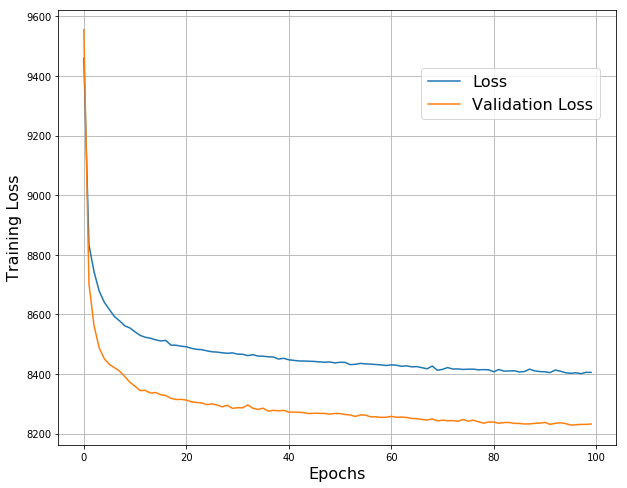

In [14]:
import matplotlib.font_manager
history_df = pd.DataFrame(fit_hist.history)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
loss_plot, = ax.plot(fit_hist.history['loss'])
val_loss_plot, = ax.plot(fit_hist.history['val_loss'])
ax.set_xlabel('Epochs', fontsize = 16, fontname='Times New Roman')
ax.set_ylabel('Training Loss', fontsize = 16, fontname='Times New Roman')

leg = ax.legend((loss_plot, val_loss_plot),
           ('Loss', 'Validation Loss'),
           scatterpoints=1,
           markerscale=2.5,
           loc=(0.65,0.75),
           ncol=1,
           fontsize=16)

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.grid()

In [15]:
fig.savefig("../figures/vae_training_history_archs4.pdf", bbox_inches='tight')

### Get the embedding of the BRCA training data

In [16]:
X_brca_train_scaled = pd.DataFrame(scaler.fit_transform(X_brca_train), columns=X_brca_train.columns)

In [17]:
embeddings_before_class = encoder_get_embedding.predict(X_brca_train_scaled)

In [18]:
embeddings_before_class

array([[ 0.8364548 ,  0.85642016,  0.9666141 , ...,  1.0574418 ,
         2.314868  ,  1.506012  ],
       [ 1.3130811 , -0.55976266, -0.32714927, ..., -0.17414984,
         2.4353518 ,  1.5432158 ],
       [-0.23583145,  0.07001747,  0.5843296 , ...,  1.9019996 ,
         2.1720133 ,  3.073222  ],
       ...,
       [ 0.5615649 ,  0.32525906, -0.18899253, ...,  0.07399294,
        -0.5240022 ,  2.4460044 ],
       [ 1.2895303 ,  0.45847446,  0.57646704, ..., -0.11840735,
         0.19328243,  2.233236  ],
       [ 1.185863  , -0.2986681 ,  2.5921361 , ...,  0.8697984 ,
         1.4275159 ,  4.1889343 ]], dtype=float32)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings_before_class)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_brca_train], axis="columns")

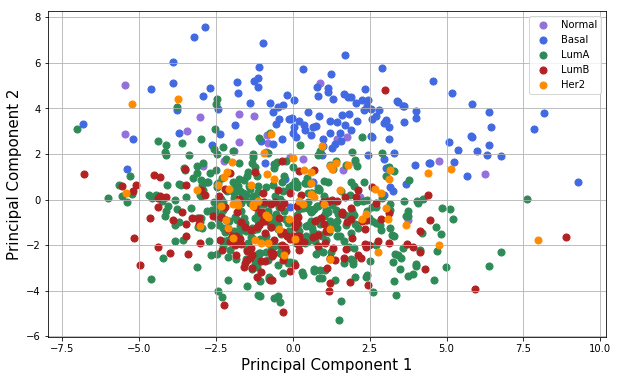

In [20]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = ['Normal', 'Basal', 'LumA', 'LumB', 'Her2']
colors = ['mediumpurple', 'royalblue', 'seagreen', 'firebrick', 'darkorange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Ciriello_subtype'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [21]:
fig.savefig("../figures/embedding_before_classifier_archs4.pdf", bbox_inches='tight')

### Now we stack the classifier and train it with the BRCA labeled samples

In [22]:
classifier_output = Dense(5, activation="softmax", name="classifier_output")(concatenate([z_mean_encoded, z_log_var_encoded], axis=1))

classifier = Model(inputs, classifier_output, name="classifier")
adam = optimizers.Adam(lr=learning_rate)
classifier.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 19036)        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 19036)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          5711100     dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 300)          1200        dense[0][0]                      
__________________________________________________________________________________________________
activation

In [23]:
enc = OneHotEncoder(sparse=False)
y_brca_train_onehot = enc.fit_transform(y_brca_train.values.reshape(-1, 1))

X_train_train, X_train_val, y_labels_train_train, y_labels_train_val = train_test_split(X_brca_train_scaled, y_brca_train_onehot, test_size=0.2, stratify=y_brca_train, random_state=42)
fit_hist = classifier.fit(x=X_train_train, 
                                y=y_labels_train_train, 
                                shuffle=True, 
                                epochs=100,
                                batch_size=50,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                                validation_data=(X_train_val, y_labels_train_val))

Train on 653 samples, validate on 164 samples
Epoch 1/100
653/653 [==============================] - 2s 3ms/sample - loss: 1.4687 - acc: 0.3828 - val_loss: 1.5449 - val_acc: 0.3537
Epoch 2/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.9945 - acc: 0.6585 - val_loss: 1.3293 - val_acc: 0.6037
Epoch 3/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.8480 - acc: 0.7198 - val_loss: 1.2217 - val_acc: 0.6463
Epoch 4/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.7393 - acc: 0.7366 - val_loss: 1.1333 - val_acc: 0.6524
Epoch 5/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.6829 - acc: 0.7703 - val_loss: 1.0372 - val_acc: 0.6585
Epoch 6/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.6182 - acc: 0.7596 - val_loss: 0.9736 - val_acc: 0.6646
Epoch 7/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.5855 - acc: 0.7795 - val_loss: 0.8689 - val_acc: 0.6707
Epoch 8/1

### Get embeddings after training the classifier and plot PCA

In [25]:
embeddings_after = encoder_get_embedding.predict(X_brca_train_scaled)

In [27]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings_after)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_brca_train], axis="columns")

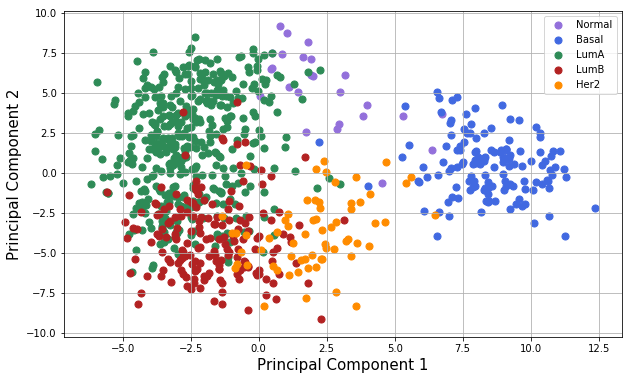

In [28]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = ['Normal', 'Basal', 'LumA', 'LumB', 'Her2']
colors = ['mediumpurple', 'royalblue', 'seagreen', 'firebrick', 'darkorange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Ciriello_subtype'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [29]:
fig.savefig("../figures/embedding_after_classifier_archs4.pdf", bbox_inches='tight')